In [1]:
!pip install xgboost


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# 1. Dataset preparation

In [3]:
df_full = pd.read_csv('diabetes_prediction_dataset.csv')

There is a strong class imbalance in the source dataset:

In [4]:
(df_full['diabetes'] == 0).sum() / len(df_full), (df_full['diabetes'] == 1).sum() / len(df_full)

(np.float64(0.915), np.float64(0.085))

Extract a small part (2000 objects) from the full dataset 

In [5]:
from sklearn.model_selection import train_test_split

# does not work due to class imbalance
# df, _ = train_test_split(
#     df_full,
#     train_size=2000,
#     stratify=df_full['diabetes'],
#     random_state=42
# )

df0 = df_full[df_full['diabetes'] == 0]
df1 = df_full[df_full['diabetes'] == 1]

df = pd.concat([
    df0.sample(1000, random_state=42),
    df1.sample(1000, random_state=42)
])

df = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [6]:
df_full.shape, df.shape

((100000, 9), (2000, 9))

In [7]:
(df['diabetes'] == 0).sum() / len(df), (df['diabetes'] == 1).sum() / len(df)

(np.float64(0.5), np.float64(0.5))

# 2. Dataset analysis

Features:
- **Gender** - male, female or other
- **Age** - a range from 0 to 80 years
- **Hypertension** is a medical condition in which the blood pressure in the arteries is persistently elevated (binary)
- **Heart disease** is medical condition that is associated with an increased risk of developing diabetes (binary)
- **Smoking history** is a risk factor for diabetes and can exacerbate the complications associated with diabetes.There 5 categories i.e *not current*, *former*, *No Info*, *current*, *never* and *ever*
- **BMI** (Body Mass Index) is a measure of body fat based on weight and height. Higher BMI values are linked to a higher risk of diabetes. The range of BMI in the dataset is from 10.16 to 71.55. BMI less than 18.5 is underweight, 18.5-24.9 is normal, 25-29.9 is overweight, and 30 or more is obese
- **HbA1c** (Hemoglobin A1c) level is a measure of a person's average blood sugar level over the past 2-3 months. Higher levels indicate a greater risk of developing diabetes. Mostly more than 6.5% of HbA1c Level indicates diabetes
- **Blood glucose level** refers to the amount of glucose in the bloodstream at a given time. High blood glucose levels are a key indicator of diabetes

Target:
- **Diabetes** is the target variable being predicted, with values of 1 indicating the presence of diabetes and 0 indicating the absence of diabetes

In [8]:
df.head(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,1,1,No Info,25.60,7.5,300,1
1,Female,42.0,0,0,never,27.32,5.8,85,0
2,Female,68.0,1,0,not current,37.39,7.0,280,1
3,Male,27.0,0,0,No Info,27.32,6.6,160,0
4,Female,80.0,1,0,No Info,20.78,8.2,240,1
5,Male,69.0,0,0,not current,27.32,6.0,155,1
6,Male,21.0,0,0,never,23.39,4.0,130,0
7,Female,61.0,0,0,No Info,27.32,5.8,159,1
8,Female,10.0,0,0,No Info,27.32,4.0,90,0
9,Female,80.0,0,0,never,31.42,6.8,126,1


In [9]:
num_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
cat_cols = ['gender', 'smoking_history']
binary_cols = ['hypertension', 'heart_disease']

In [10]:
df[num_cols].describe()

,age,bmi,HbA1c_level,blood_glucose_level
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,50.788860,29.353730,6.135200,163.164000
std,21.363969,7.498109,1.280543,57.660693
min,0.160000,10.300000,3.500000,80.000000
25%,36.000000,25.640000,5.700000,130.000000
50%,55.000000,27.320000,6.100000,155.000000
75%,67.000000,32.810000,6.600000,200.000000
max,80.000000,70.960000,9.000000,300.000000


There are no "None" values in the dataset

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               2000 non-null   object 
 1   age                  2000 non-null   float64
 2   hypertension         2000 non-null   int64  
 3   heart_disease        2000 non-null   int64  
 4   smoking_history      2000 non-null   object 
 5   bmi                  2000 non-null   float64
 6   HbA1c_level          2000 non-null   float64
 7   blood_glucose_level  2000 non-null   int64  
 8   diabetes             2000 non-null   int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 140.8+ KB


In [12]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [13]:
# No need to fill None-values
# for col in num_cols:
#     df[col] = df[col].fillna(df[col].mean())

# for col in cat_cols:
#     df[col] = df[col].fillna(df[col].mode()[0])

Observe feature distributions

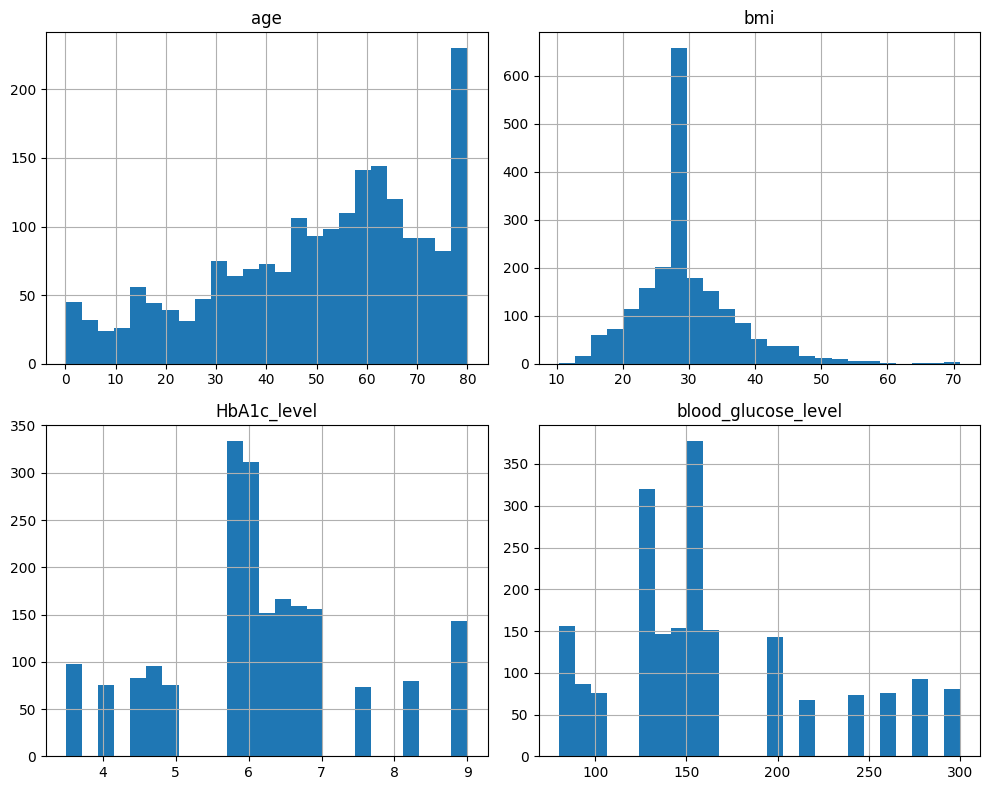

In [14]:
df[num_cols].hist(figsize=(10,8), bins=25)
plt.tight_layout()
plt.show()

gender
Female    1137
Male       863
Name: count, dtype: int64


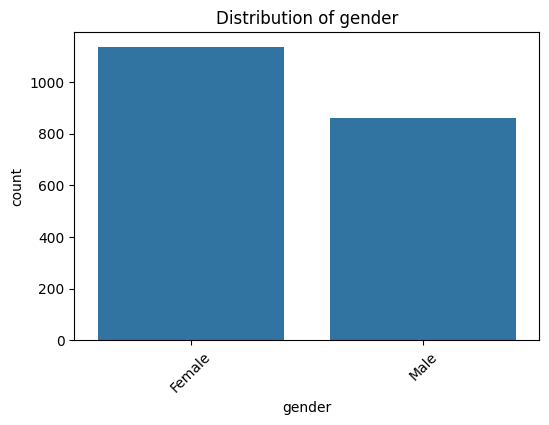

smoking_history
never          738
No Info        539
former         264
current        202
not current    160
ever            97
Name: count, dtype: int64


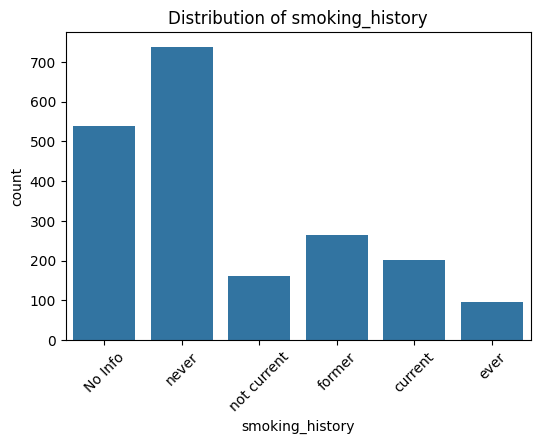

In [15]:
for col in cat_cols:
    print(df[col].value_counts())
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

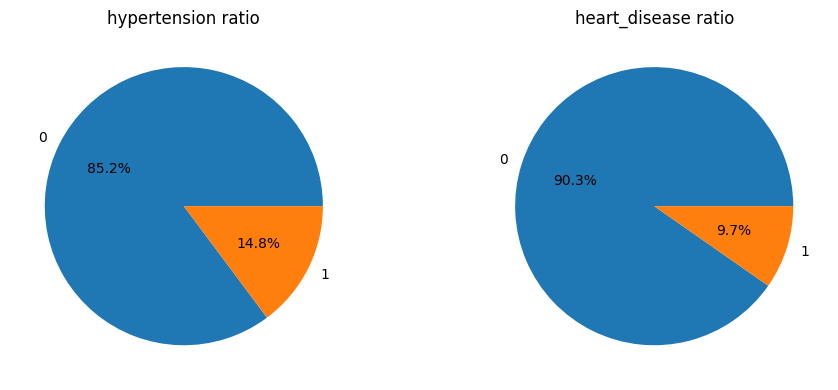

In [16]:
fig, axes = plt.subplots(1, len(binary_cols), figsize=(10, 4))

for ax, col in zip(axes, binary_cols):
    df[col].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax)
    ax.set_title(f"{col} ratio")
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

Analyze the connection between the features and the target

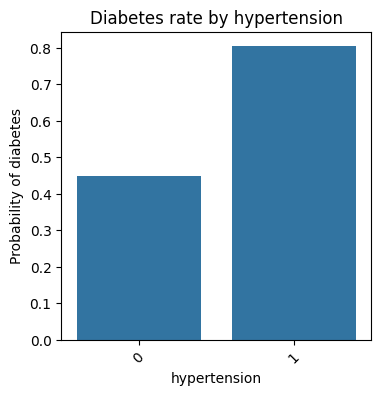

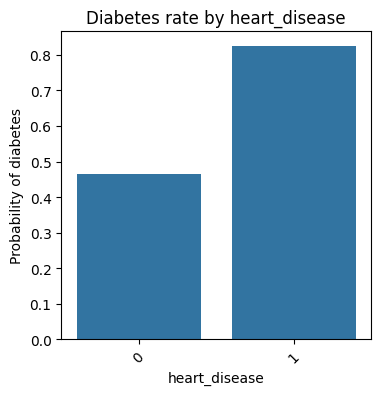

In [17]:
for col in binary_cols:
    plt.figure(figsize=(4,4))
    rate = df.groupby(col)['diabetes'].mean()
    sns.barplot(x=rate.index, y=rate.values)
    plt.title(f"Diabetes rate by {col}")
    plt.ylabel("Probability of diabetes")
    plt.xticks(rotation=45)
    plt.show()

### The influence of the categorical features on the probability of diabetes

According to the charts, men are more likely to develop diabetes. Regarding smoking history, diabetes is more common among former smokers

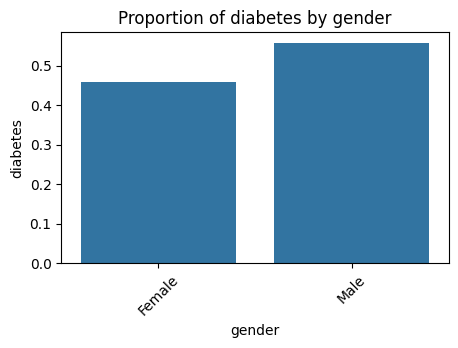

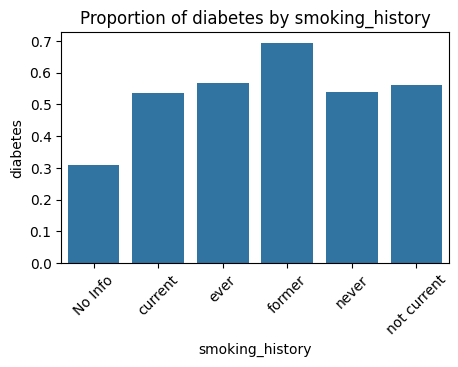

In [18]:
for col in cat_cols:
    plt.figure(figsize=(5,3))
    prop = (df.groupby(col)['diabetes']
              .mean()
              .reset_index())
    sns.barplot(data=prop, x=col, y='diabetes')
    plt.title(f"Proportion of diabetes by {col}")
    plt.xticks(rotation=45)
    plt.show()

### The influence of the numerical features on the probability of diabetes
- Diabetics are usually older
- On average, diabetics have a slightly higher BMI, but the difference is small
- Greater diversity of clinical conditions for HbA1c, bias towards higher values
- Glucose levels for people with diabetes lie in a wider range, there is a subgroup with high values

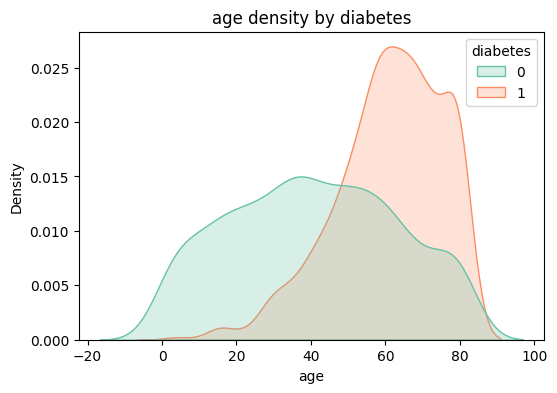

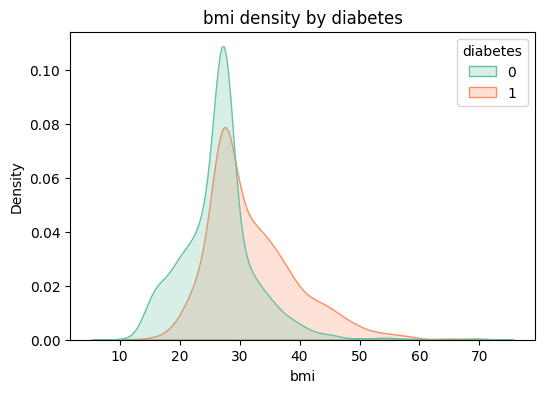

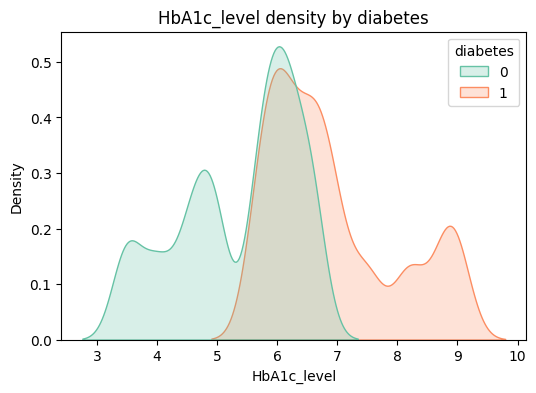

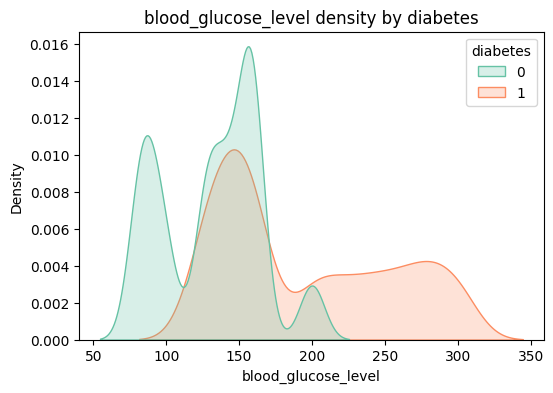

In [19]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=df, x=col, hue='diabetes', common_norm=False, palette="Set2", fill=True)
    plt.title(f"{col} density by diabetes")
    plt.show()

# 3. Feature Engineering

Remove raws with the value "other"

In [20]:
df_processed = df.copy()

In [21]:
df_processed = df_processed[df_processed['gender'] != 'other'].copy()
df_processed['gender'].unique()

array(['Female', 'Male'], dtype=object)

Replace 'gender' with a binary column

In [22]:
df_processed['male'] = (df_processed['gender'] == 'Male').astype(int)
df_processed = df_processed.drop(columns=['gender'])
df_processed[['male']].head()

,male
0,0
1,0
2,0
3,1
4,0


Replace *not current* with *former* for "smoking_history" feature

In [23]:
df_processed.loc[df_processed['smoking_history'] == 'not current', 'smoking_history'] = 'former'
df_processed['smoking_history'].unique()

array(['No Info', 'never', 'former', 'current', 'ever'], dtype=object)

Replace *No Info* with *unknown*

In [24]:
df_processed['smoking_history'] = df_processed['smoking_history'].replace('No Info', 'unknown')

Apply one-hot-encoding to the "smoking_history" column

In [25]:
df_processed['smoking_history'] = df_processed['smoking_history'].fillna('unknown')
df_processed['smoking_history'] = df_processed['smoking_history'].replace({'No Info': 'unknown', 'not current': 'former'})

smoking_dummies = pd.get_dummies(df_processed['smoking_history'], prefix='smoking')

df_processed = pd.concat([df_processed.drop(columns=['smoking_history']), smoking_dummies], axis=1)

In [26]:
df_processed.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,male,smoking_current,smoking_ever,smoking_former,smoking_never,smoking_unknown
0,80.0,1,1,25.60,7.5,300,1,0,False,False,False,False,True
1,42.0,0,0,27.32,5.8,85,0,0,False,False,False,True,False
2,68.0,1,0,37.39,7.0,280,1,0,False,False,True,False,False
3,27.0,0,0,27.32,6.6,160,0,1,False,False,False,False,True
4,80.0,1,0,20.78,8.2,240,1,0,False,False,False,False,True


### Correlation

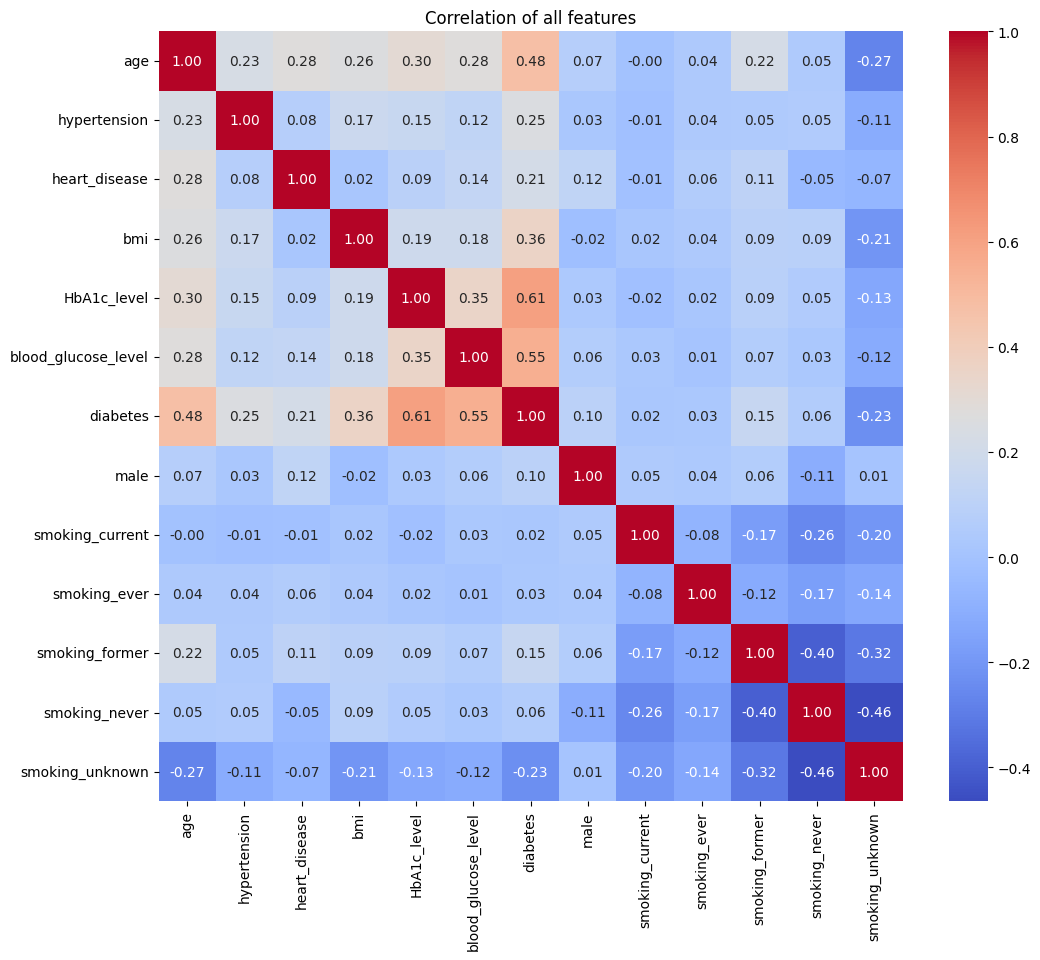

In [27]:
corr = df_processed.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation of all features")
plt.show()

# 4. Training and testing
### Train and test splitting

In [28]:
target = 'diabetes'  
X = df_processed.drop(columns=[target])
y = df_processed[target]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Scaling (mean=0, std=1)

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
    ],
    remainder='passthrough' 
)

### Training procedure

In [31]:
models = {
    'kNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss', random_state=42)
}

In [32]:
results = {}

for name, model in models.items():
    print(f"Training model: {name}")
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    results[name] = f1

Training model: kNN
Training model: Naive Bayes
Training model: Logistic Regression
Training model: SVM
Training model: Decision Tree
Training model: Random Forest
Training model: XGBoost


In [33]:
interpret_params = {}
results = {}

for name, model in models.items():
    print(f"Training model: {name}")
    
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    
    clf.fit(X_train, y_train)
    
    fitted_model = clf.named_steps['classifier']
    
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    results[name] = f1
    
    params = {}
    if name == 'kNN':
        params['n_neighbors'] = fitted_model.n_neighbors
        params['num_features'] = X_train.shape[1]
    elif name == 'Naive Bayes':
        params['class_prior'] = fitted_model.class_prior_
        params['variance'] = fitted_model.var_.tolist()  
        params['mean'] = fitted_model.theta_.tolist()    

    elif name == 'Logistic Regression':
        params['coefficients'] = fitted_model.coef_.tolist()
        params['intercept'] = fitted_model.intercept_.tolist()
    elif name == 'SVM':
        params['support_vectors'] = fitted_model.support_vectors_.tolist()
        params['dual_coef'] = fitted_model.dual_coef_.tolist()
        params['intercept'] = fitted_model.intercept_.tolist()
    elif name == 'Decision Tree':
        params['max_depth'] = fitted_model.get_depth()
        params['num_leaves'] = fitted_model.get_n_leaves()
        params['feature_importances'] = fitted_model.feature_importances_.tolist()
    elif name == 'Random Forest':
        params['n_trees'] = len(fitted_model.estimators_)
        params['max_depth'] = [est.get_depth() for est in fitted_model.estimators_]
        params['feature_importances'] = fitted_model.feature_importances_.tolist()
    elif name == 'XGBoost':
        params['n_trees'] = fitted_model.n_estimators
        params['max_depth'] = fitted_model.max_depth
        params['feature_importances'] = fitted_model.feature_importances_.tolist()
    
    interpret_params[name] = {'f1': f1, 'params': params}

for model_name, info in interpret_params.items():
    print(f"\nModel: {model_name}, F1: {info['f1']:.3f}")
    for param_name, value in info['params'].items():
        if isinstance(value, list) and len(value) > 10:
            print(f"  {param_name}: [{', '.join(map(str, value[:5]))}, ..., {len(value)} values]")
        else:
            print(f"  {param_name}: {value}")


Training model: kNN
Training model: Naive Bayes
Training model: Logistic Regression
Training model: SVM
Training model: Decision Tree
Training model: Random Forest
Training model: XGBoost

Model: kNN, F1: 0.884
  n_neighbors: 5
  num_features: 12

Model: Naive Bayes, F1: 0.806
  class_prior: [0.5 0.5]
  variance: [[1.0893573649820438, 0.7366750230070913, 0.5880541852784026, 0.3376256121378332, 0.05529843849999935, 0.031443751000000464, 0.23499375099999872, 0.080873438500001, 0.0372484384999997, 0.12662343850000152, 0.22236093849999938, 0.23790000099999797], [0.4578310122155411, 1.0187723133136275, 0.6806618975347482, 1.0487534822209559, 0.1791109385000011, 0.13269375099999847, 0.2493109385000002, 0.09887343849999919, 0.05197500100000032, 0.19710000100000163, 0.23871093849999933, 0.14110000099999773]]
  mean: [[-0.47582119793175104, -0.34968032950059147, -0.604683354817563, -0.5539047335242812, 0.05875, 0.0325, 0.3775, 0.08875, 0.03875, 0.14875, 0.33375, 0.39], [0.47582119793175276, 0.3

In [34]:
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'F1 Score'])
results_df.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)

,Model,F1 Score
0,SVM,0.905852
1,Random Forest,0.905000
2,kNN,0.883838
3,Logistic Regression,0.883249
4,XGBoost,0.869565
5,Decision Tree,0.853598
6,Naive Bayes,0.806283


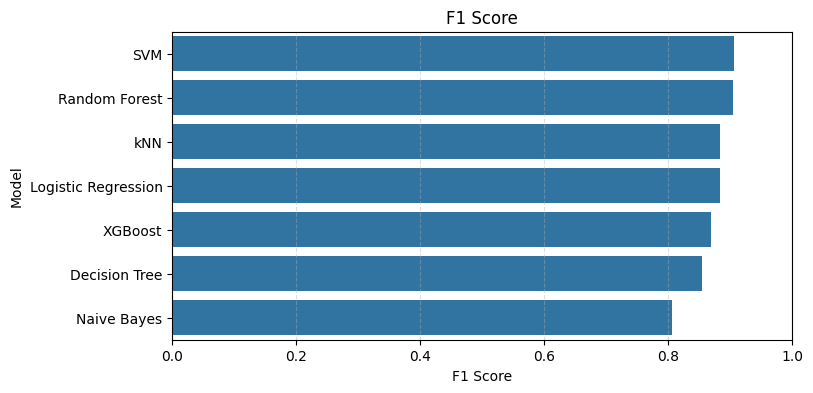

In [35]:
plt.figure(figsize=(8, 4))

sns.barplot(
    data=results_df.sort_values(by="F1 Score", ascending=False),
    x="F1 Score",
    y="Model"
)

plt.title("F1 Score")
plt.xlabel("F1 Score")
plt.ylabel("Model")
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.4)

plt.show()

# LazyFCA

In [36]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,1,1,No Info,25.60,7.5,300,1
1,Female,42.0,0,0,never,27.32,5.8,85,0
2,Female,68.0,1,0,not current,37.39,7.0,280,1
3,Male,27.0,0,0,No Info,27.32,6.6,160,0
4,Female,80.0,1,0,No Info,20.78,8.2,240,1


### Binarization (only for categorical features)

In [37]:
df_fca = df.copy()

In [38]:
df_fca = df.copy()
df_fca = df_fca[df_fca['gender'] != 'other'].copy()
df_fca['male'] = (df_fca['gender'] == 'Male').astype(int)
df_fca = df_fca.drop(columns=['gender'])

In [39]:
df_fca.loc[df_fca['smoking_history'] == 'not current', 'smoking_history'] = 'former'

df_fca['smoking_history'] = df_fca['smoking_history'].replace('No Info', 'unknown')
df_fca['smoking_history'] = df_fca['smoking_history'].fillna('unknown')
df_fca['smoking_history'] = df_fca['smoking_history'].replace({'No Info': 'unknown', 'not current': 'former'})

smoking_dummies = pd.get_dummies(df_fca['smoking_history'], prefix='smoking')
df_fca = pd.concat([df_fca.drop(columns=['smoking_history']), smoking_dummies], axis=1)

In [40]:
df_fca.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,male,smoking_current,smoking_ever,smoking_former,smoking_never,smoking_unknown
0,80.0,1,1,25.60,7.5,300,1,0,False,False,False,False,True
1,42.0,0,0,27.32,5.8,85,0,0,False,False,False,True,False
2,68.0,1,0,37.39,7.0,280,1,0,False,False,True,False,False
3,27.0,0,0,27.32,6.6,160,0,1,False,False,False,False,True
4,80.0,1,0,20.78,8.2,240,1,0,False,False,False,False,True


### Train and test splitting

In [41]:
target = 'diabetes'  
X_fca = df_fca.drop(columns=[target])
y_fca = df_fca[target]

In [42]:
X_train_fca, X_test_fca, y_train_fca, y_test_fca = train_test_split(
    X_fca, y_fca, test_size=0.2, random_state=42, stratify=y_fca
)

In [43]:
X_train_fca.shape, X_test_fca.shape

((1600, 12), (400, 12))

### LazyFCA algorithm

In [48]:
from typing import Any, List

MAX_RULE_SIZE = 5

class LazyClassifierFCA:
    def __init__(self):
        self.X_train = None
        self.y_train = None

        self.rules_type = {
            'age': 'interval',
            'bmi': 'interval',
            'HbA1c_level': 'interval',
            'blood_glucose_level': 'interval'
        }

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series) -> None:
        self.X_train = X_train
        self.y_train = y_train

        self.pos_idx = (y_train == 1).values
        self.neg_idx = (y_train == 0).values

        self.X_pos = X_train[self.pos_idx]
        self.X_neg = X_train[self.neg_idx]

        self.binary_cols = X_train.select_dtypes(include='bool').columns
        self.num_cols = X_train.select_dtypes(exclude='bool').columns

        self.binary_pos_np = self.X_pos[self.binary_cols].values.astype(bool)
        self.binary_neg_np = self.X_neg[self.binary_cols].values.astype(bool)

        self.num_pos_np = self.X_pos[self.num_cols].values.astype(float)
        self.num_neg_np = self.X_neg[self.num_cols].values.astype(float)

        self.pos_indices = self.X_pos.index
        self.neg_indices = self.X_neg.index

    
    def compute_intervals(self, sample_values, train_values):
        intervals = []
        for i, col in enumerate(self.num_cols):
            rule = self.rules_type.get(col, 'interval')
            s_val = sample_values[i]
            t_val = train_values[i]

            if rule == 'interval':
                intervals.append([min(s_val, t_val), max(s_val, t_val)])
            elif rule == 'min':
                intervals.append([min(s_val, t_val), np.inf])
            elif rule == 'max':
                intervals.append([-np.inf, max(s_val, t_val)])
            else:
                intervals.append([min(s_val, t_val), max(s_val, t_val)])

        return np.array(intervals)

    def classify_sample(self, sample: pd.Series, verbose: bool = False) -> Any:
        sample_bin = sample[self.binary_cols].values.astype(bool)
        sample_num = sample[self.num_cols].values.astype(float)
    
        positive_classifiers = 0
        negative_classifiers = 0
        positive_rule_sizes = []
        negative_rule_sizes = []
    
        def find_number_of_matches(binary_train, num_train,
                                  binary_intersection, numerical_intervals,
                                  train_indices):
            mask_bin = np.all(binary_train | (~binary_intersection), axis=1)
            lows = numerical_intervals[:, 0]
            highs = numerical_intervals[:, 1]
            mask_num = np.all((num_train >= lows) & (num_train <= highs), axis=1)
            mask = mask_bin & mask_num
            return np.sum(mask)
    
        # -------- Positive rules --------
        for p_i in range(self.X_pos.shape[0]):
            pos_sample_bin = self.binary_pos_np[p_i]
            pos_sample_num = self.num_pos_np[p_i]
    
            binary_intersection = sample_bin & pos_sample_bin
            numerical_intervals = self.compute_intervals(sample_num, pos_sample_num)
    
            num_positive = find_number_of_matches(
                self.binary_pos_np, self.num_pos_np,
                binary_intersection, numerical_intervals,
                self.pos_indices
            )
            num_negative = find_number_of_matches(
                self.binary_neg_np, self.num_neg_np,
                binary_intersection, numerical_intervals,
                self.neg_indices
            )
    
            ratio_pos = num_positive / len(self.pos_indices)
            rule_size = np.sum(binary_intersection) + np.sum(numerical_intervals[:, 1] > numerical_intervals[:, 0])
    
            if num_negative == 0 and num_positive > 1 and ratio_pos >= MIN_RATIO and rule_size <= MAX_RULE_SIZE:
                positive_classifiers += 1
                positive_rule_sizes.append(rule_size)
    
        # -------- Negative rules --------
        for n_i in range(self.X_neg.shape[0]):
            neg_sample_bin = self.binary_neg_np[n_i]
            neg_sample_num = self.num_neg_np[n_i]
    
            binary_intersection = sample_bin & neg_sample_bin
            numerical_intervals = self.compute_intervals(sample_num, neg_sample_num)
    
            num_positive = find_number_of_matches(
                self.binary_pos_np, self.num_pos_np,
                binary_intersection, numerical_intervals,
                self.pos_indices
            )
            num_negative = find_number_of_matches(
                self.binary_neg_np, self.num_neg_np,
                binary_intersection, numerical_intervals,
                self.neg_indices
            )
    
            ratio_neg = num_negative / len(self.neg_indices)
            rule_size = np.sum(binary_intersection) + np.sum(numerical_intervals[:, 1] > numerical_intervals[:, 0])
    
            if num_positive == 0 and ratio_neg >= MIN_RATIO and num_negative > 1 and rule_size <= MAX_RULE_SIZE:
                negative_classifiers += 1
                negative_rule_sizes.append(rule_size)
    
        avg_pos_rule_size = np.mean(positive_rule_sizes) if positive_rule_sizes else 0
        avg_neg_rule_size = np.mean(negative_rule_sizes) if negative_rule_sizes else 0
    
        if positive_classifiers > negative_classifiers:
            return 1, positive_classifiers, negative_classifiers, avg_pos_rule_size, avg_neg_rule_size
        elif negative_classifiers > positive_classifiers:
            return 0, positive_classifiers, negative_classifiers, avg_pos_rule_size, avg_neg_rule_size
        else:
            return 1, positive_classifiers, negative_classifiers, avg_pos_rule_size, avg_neg_rule_size

    def predict(self, X_test: pd.DataFrame, verbose: bool = False) -> List[Any]:
        return [self.classify_sample(sample, verbose)
                for _, sample in X_test.iterrows()]


In [49]:
def experiment_ratio(lfca: LazyClassifierFCA, X_test: pd.DataFrame, y_test: pd.Series, ratios: list):
    pos_counts = []
    neg_counts = []
    f1_scores = []

    global MIN_RATIO

    for r in ratios:
        MIN_RATIO = r
        positive_sum = 0
        negative_sum = 0
        y_pred = []

        for idx, sample in X_test.iterrows():
            pred, pos_c, neg_c, avg_pos_rule_size, avg_neg_rule_size = lfca.classify_sample(sample)
            y_pred.append(pred)
            positive_sum += pos_c
            negative_sum += neg_c

        pos_counts.append(positive_sum / len(X_test))
        neg_counts.append(negative_sum / len(X_test))
        f1_scores.append(f1_score(y_test, y_pred))

        print(f"MIN_RATIO={r:.2f} | avg_pos={pos_counts[-1]:.2f} | avg_neg={neg_counts[-1]:.2f} | F1={f1_scores[-1]:.2f}")

    MIN_RATIO = 0
    return pos_counts, neg_counts, f1_scores


def experiment_rule_size(lfca: LazyClassifierFCA, X_test: pd.DataFrame, y_test: pd.Series, rule_sizes: list):
    pos_counts = []
    neg_counts = []
    f1_scores = []

    global MAX_RULE_SIZE

    for size in rule_sizes:
        MAX_RULE_SIZE = size
        positive_sum = 0
        negative_sum = 0
        y_pred = []

        for idx, sample in X_test.iterrows():
            pred, pos_c, neg_c, avg_pos_rule_size, avg_neg_rule_size = lfca.classify_sample(sample)
            y_pred.append(pred)
            positive_sum += pos_c
            negative_sum += neg_c

        pos_counts.append(positive_sum / len(X_test))
        neg_counts.append(negative_sum / len(X_test))
        f1_scores.append(f1_score(y_test, y_pred))

        print(f"MAX_RULE_SIZE={size} | avg_pos={pos_counts[-1]:.2f} | avg_neg={neg_counts[-1]:.2f} | F1={f1_scores[-1]:.2f}")

    MAX_RULE_SIZE = 10
    return pos_counts, neg_counts, f1_scores

In [50]:
ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
rule_sizes = range(1, 9)

MIN_RATIO=0.00 | avg_pos=115.81 | avg_neg=172.50 | F1=0.90
MIN_RATIO=0.10 | avg_pos=0.02 | avg_neg=0.24 | F1=0.71
MIN_RATIO=0.20 | avg_pos=0.00 | avg_neg=0.01 | F1=0.67
MIN_RATIO=0.30 | avg_pos=0.00 | avg_neg=0.00 | F1=0.67
MIN_RATIO=0.40 | avg_pos=0.00 | avg_neg=0.00 | F1=0.67
MIN_RATIO=0.50 | avg_pos=0.00 | avg_neg=0.00 | F1=0.67


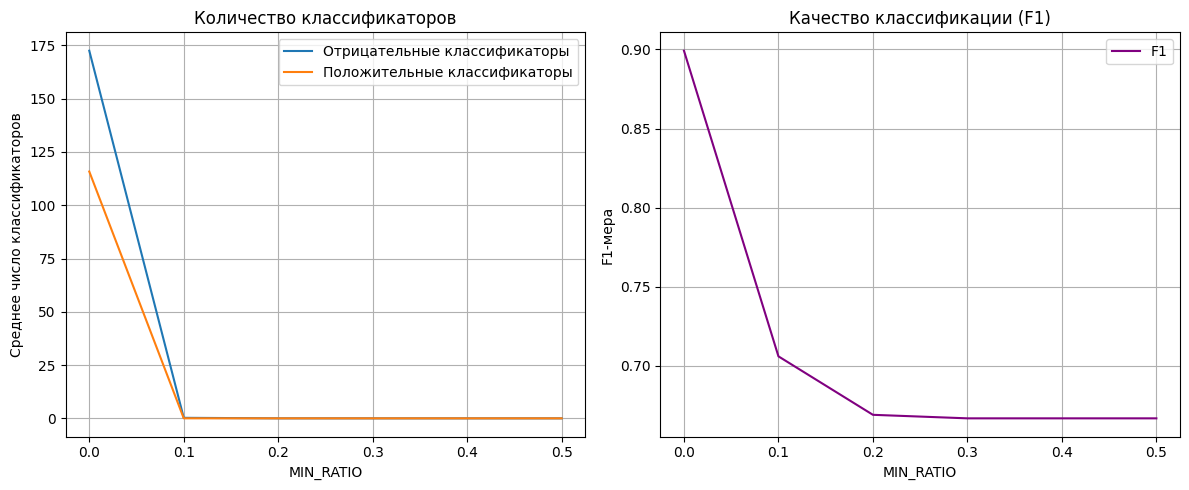

In [51]:
classifier_ratios = LazyClassifierFCA()
classifier_ratios.fit(X_train_fca, y_train_fca)

pos_r, neg_r, f1_r = experiment_ratio(classifier_ratios, X_test_fca, y_test_fca, ratios)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(ratios, neg_r, label='Отрицательные классификаторы')
plt.plot(ratios, pos_r, label='Положительные классификаторы')
plt.xlabel('MIN_RATIO')
plt.grid(True)
plt.ylabel('Среднее число классификаторов')
plt.title('Количество классификаторов')
plt.legend()

plt.subplot(1,2,2)
plt.plot(ratios, f1_r, label='F1', color='purple')
plt.xlabel('MIN_RATIO')
plt.ylabel('F1-мера')
plt.grid(True)
plt.title('Качество классификации (F1)')
plt.legend()
plt.tight_layout()
plt.show()

MAX_RULE_SIZE=1 | avg_pos=0.01 | avg_neg=0.01 | F1=0.67
MAX_RULE_SIZE=2 | avg_pos=0.32 | avg_neg=1.02 | F1=0.73
MAX_RULE_SIZE=3 | avg_pos=6.22 | avg_neg=17.36 | F1=0.82
MAX_RULE_SIZE=4 | avg_pos=45.30 | avg_neg=90.80 | F1=0.87
MAX_RULE_SIZE=5 | avg_pos=115.81 | avg_neg=172.50 | F1=0.90
MAX_RULE_SIZE=6 | avg_pos=169.18 | avg_neg=205.12 | F1=0.90
MAX_RULE_SIZE=7 | avg_pos=187.39 | avg_neg=209.69 | F1=0.89
MAX_RULE_SIZE=8 | avg_pos=189.23 | avg_neg=209.99 | F1=0.89


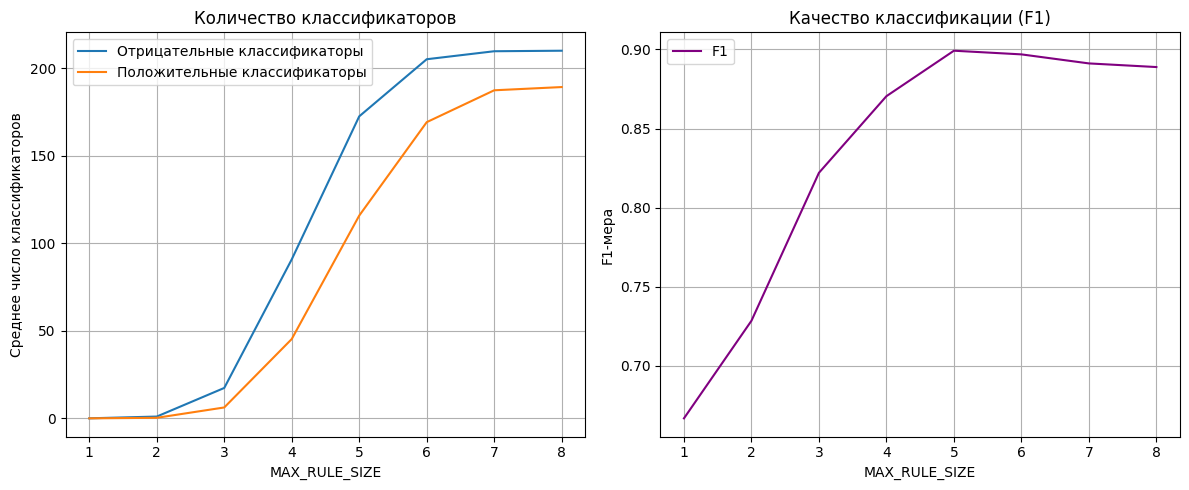

In [52]:
classifier_rules = LazyClassifierFCA()
classifier_rules.fit(X_train_fca, y_train_fca)

pos_s, neg_s, f1_s = experiment_rule_size(classifier_rules, X_test_fca, y_test_fca, rule_sizes)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(rule_sizes, neg_s, label='Отрицательные классификаторы')
plt.plot(rule_sizes, pos_s, label='Положительные классификаторы')
plt.xlabel('MAX_RULE_SIZE')
plt.grid(True)
plt.ylabel('Среднее число классификаторов')
plt.title('Количество классификаторов')
plt.legend()

plt.subplot(1,2,2)
plt.plot(rule_sizes, f1_s, label='F1', color='purple')
plt.xlabel('MAX_RULE_SIZE')
plt.ylabel('F1-мера')
plt.grid(True)
plt.title('Качество классификации (F1)')
plt.legend()
plt.tight_layout()
plt.show()

### Best model

In [53]:
MIN_RATIO = 0 
MAX_RULE_SIZE = 5

In [ ]:
classifier = LazyClassifierFCA()
classifier.fit(X_train_fca, y_train_fca)
fca_results = classifier.predict(X_test_fca, verbose=False)

In [ ]:
y_pred_fca, positive_classifiers, negative_classifiers, avg_pos_rule_size, avg_neg_rule_size = zip(*fca_results)
y_pred_fca = list(y_pred_fca)
positive_classifiers = list(positive_classifiers)
negative_classifiers = list(negative_classifiers)
f1_fca = f1_score(y_test_fca, y_pred_fca)

In [ ]:
print(f"LazyFCA F1-score: {f1_fca}")
print(f"Positive classifiers: {sum(positive_classifiers)/len(positive_classifiers)}. Average size: {sum(avg_pos_rule_size)/len(avg_pos_rule_size)}")
print(f"Negative classifiers: {sum(negative_classifiers)/len(negative_classifiers)}. Average size: {sum(avg_neg_rule_size)/len(avg_neg_rule_size)}")